In [37]:
# ============================================================
# 1. IMPORTS & CONFIG
# ============================================================

from __future__ import annotations
import os
from dataclasses import dataclass
from typing import List, Dict

import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import torch.nn.utils as utils # For gradient clipping
from sklearn.metrics import roc_curve, auc
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@dataclass
class TFTConfig:
    n_past_games: int = 5               # encoder length
    batch_size: int = 64
    hidden_size: int = 64
    num_heads: int = 2          # heads so 32 dimension per head
    dropout: float = 0.1
    n_epochs: int = 20
    lr: float = 1e-3
    #weight_decay: float = 1e-2 # L2 Regularization for smoothness

data_dir = "data"


# ============================================================
# 2. DATA LOADING & FEATURE ENGINEERING
# ============================================================

static_categoricals = [
    "athlete_id", "team", "opposing_team", "position", "home_away"
]

known_future_categoricals = [
    "team", "opposing_team", "home_away", "position"
]

known_future_numerics = [
    "season"
]

# All numeric observed stats become observed past inputs
def load_stat_df(stat_name: str) -> pd.DataFrame:
    train_path = os.path.join(data_dir, f"{stat_name}_2019_2023.csv")
    test_path  = os.path.join(data_dir, f"{stat_name}_24tocurrent.csv")

    df_train = pd.read_csv(train_path, parse_dates=["date"])
    df_test  = pd.read_csv(test_path,  parse_dates=["date"])

    #df = pd.concat([df_train, df_test], ignore_index=True)
    df_train = df_train.sort_values(["athlete_id", "date"]).reset_index(drop=True)
    df_test = df_test.sort_values(["athlete_id", "date"]).reset_index(drop=True)
    
    return df_train, df_test


class TFTDataset(Dataset):
    """
    Each item returns everything needed for TFT:
    - past observed: (T, E_obs)
    - known future: (1, E_known)
    - static categorical: (S_static,)
    - target y
    """
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]

        return (
            torch.tensor(s["past_observed"], dtype=torch.float32),
            torch.tensor(s["future_known"], dtype=torch.float32),
            torch.tensor(s["static_cat"], dtype=torch.long),
            torch.tensor(s["y"], dtype=torch.float32),
        )


# ============================================================
# CORRECTED: make_tft_sequences - Separate Train/Test
# ============================================================

def make_tft_sequences(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    target_col: str,
    window: int,
    threshold: float,
):
    """
    Build training/test sequences using TFT input format.
    Properly separates train and test data.
    Label encoders are fit on train, then applied to test.
    """
    
    # Define observed numeric features (stats)
    numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
    observed_past = [
        c for c in numeric_cols
        if c not in ["season"] and c != target_col and c != "label"
    ]

    label_encoders = {}
    
    # Helper to safely encode with an <UNK> token
    def fit_encoder_with_unk(series):
        # Add <UNK> to the unique values found in training
        unique_vals = series.astype(str).unique().tolist()
        unique_vals.append("<UNK>")
        le = LabelEncoder()
        le.fit(unique_vals)
        return le

    def transform_with_unk(le, series):
        # Map knowns to their index, unknowns to the index of <UNK>
        unk_idx = le.transform(["<UNK>"])[0]
        classes_set = set(le.classes_)
        
        return series.astype(str).apply(
            lambda x: le.transform([x])[0] if x in classes_set else unk_idx
        )

    # Fit encoders on TRAIN
    all_cats = list(set(static_categoricals + known_future_categoricals))
    for cat in all_cats:
        label_encoders[cat] = fit_encoder_with_unk(df_train[cat])

    # Transform both train and test
    df_train_encoded = df_train.copy()
    df_test_encoded = df_test.copy()

    for cat, le in label_encoders.items():
        df_train_encoded[cat] = transform_with_unk(le, df_train[cat])
        df_test_encoded[cat] = transform_with_unk(le, df_test[cat])

    # Calculate and store Normalization Stats from TRAIN data
    scaler_stats = {}
    for col in observed_past:
        mean = df_train[col].mean()
        std = df_train[col].std()
        scaler_stats[col] = (mean, std)
    
    samples_train = []
    samples_test = []

    # Process TRAIN data
    for aid, g in df_train_encoded.groupby("athlete_id"):
        g = g.sort_values("date")

        if len(g) <= window:
            continue

        # static categorical encodings
        static_vals = [
            g["athlete_id"].iloc[0],
            g["team"].iloc[0],
            g["opposing_team"].iloc[0],
            g["position"].iloc[0],
            g["home_away"].iloc[0],
        ]

        for t in range(window, len(g)):
            # observed past stats
            past_obs = g[observed_past].iloc[t-window : t].values.astype("float32")

            #Apply Normalization to past_obs (TRAIN)
            for i, col in enumerate(observed_past):
                mean, std = scaler_stats[col]
                # Apply Z-score normalization using training set stats
                if std > 1e-6:
                    past_obs[:, i] = (past_obs[:, i] - mean) / std
                else:
                    past_obs[:, i] = 0.0 # Handle constant features
            
            # known future at decoder step (t)
            fut_known_numeric = g[known_future_numerics].iloc[t:t+1].values.astype("float32")
            fut_known_cat_vals = [
                g["team"].iloc[t],
                g["opposing_team"].iloc[t],
                g["home_away"].iloc[t],
                g["position"].iloc[t],
            ]
            fut_known_cat = np.array(fut_known_cat_vals, dtype="float32").reshape(1, -1) #reshaping to 1,n
            future_known = np.concatenate([fut_known_numeric, fut_known_cat], axis=-1)

            y = g["label"].iloc[t]

            sample = {
                "past_observed": past_obs,
                "future_known": future_known,
                "static_cat": np.array(static_vals, dtype="int64"),
                "y": y,
            }
            samples_train.append(sample)

    # Process TEST data
    for aid, g in df_test_encoded.groupby("athlete_id"):
        g = g.sort_values("date")

        if len(g) <= window:
            continue

        static_vals = [
            g["athlete_id"].iloc[0],
            g["team"].iloc[0],
            g["opposing_team"].iloc[0],
            g["position"].iloc[0],
            g["home_away"].iloc[0],
        ]

        for t in range(window, len(g)):
            past_obs = g[observed_past].iloc[t-window : t].values.astype("float32")

            # Apply Normalization to past_obs (TEST) using TRAIN stats
            for i, col in enumerate(observed_past):
                mean, std = scaler_stats[col]
                if std > 1e-6:
                    past_obs[:, i] = (past_obs[:, i] - mean) / std
                else:
                    past_obs[:, i] = 0.0


            fut_known_numeric = g[known_future_numerics].iloc[t:t+1].values.astype("float32")
            fut_known_cat_vals = [
                g["team"].iloc[t],
                g["opposing_team"].iloc[t],
                g["home_away"].iloc[t],
                g["position"].iloc[t],
            ]
            fut_known_cat = np.array(fut_known_cat_vals, dtype="float32").reshape(1, -1) #reshaping to 1,n
            future_known = np.concatenate([fut_known_numeric, fut_known_cat], axis=-1)

            y = g["label"].iloc[t]

            sample = {
                "past_observed": past_obs,
                "future_known": future_known,
                "static_cat": np.array(static_vals, dtype="int64"),
                "y": y,
            }
            samples_test.append(sample)

    return TFTDataset(samples_train), TFTDataset(samples_test), observed_past, label_encoders, scaler_stats


# ============================================================
# 3. TFT BUILDING BLOCKS (GRN, VSN, LSTM, ATTENTION)
# ============================================================

class GatedResidualNetwork(nn.Module):
    def __init__(self, inp, hidden, out=None, dropout=0.1):
        super().__init__()
        out = out or inp

        self.fc1 = nn.Linear(inp, hidden)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden, out)
        self.dropout = nn.Dropout(dropout)

        # gating
        self.fc_gate = nn.Linear(out, out)
        self.sigmoid = nn.Sigmoid()

        # skip
        if inp != out:
            self.skip = nn.Linear(inp, out)
        else:
            self.skip = None

    def forward(self, x):
        residual = x if self.skip is None else self.skip(x)

        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)
        x = self.dropout(x)

        gate = self.sigmoid(self.fc_gate(x))
        return residual + gate * x


class VariableSelectionNetwork(nn.Module):
    def __init__(self, n_inputs, d_inp, hidden_size, dropout=0.1):
        super().__init__()
        self.n_inputs = n_inputs

        # GRN to compute selection weights
        self.weight_grn = GatedResidualNetwork(
            n_inputs * d_inp, hidden_size, out=n_inputs, dropout=dropout
        )
        self.softmax = nn.Softmax(dim=-1)

        # individual GRNs for each variable
        self.var_grns = nn.ModuleList([
            GatedResidualNetwork(d_inp, hidden_size, out=hidden_size, dropout=dropout)
            for _ in range(n_inputs)
        ])

    def forward(self, x):
        """
        x: (B, T, n_vars, d_input)
        """
        B, T, n_vars, d = x.shape

        # selection weights
        flat = x.reshape(B, T, n_vars * d)
        w = self.weight_grn(flat)  # (B, T, n_vars)
        w = self.softmax(w).unsqueeze(-1)  # (B, T, n_vars, 1)

        # transformed features
        var_outs = []
        for i, grn in enumerate(self.var_grns):
            v = x[:, :, i, :]
            var_outs.append(grn(v))
        var_outs = torch.stack(var_outs, dim=2)  # (B, T, n_vars, hidden)

        z = torch.sum(w * var_outs, dim=2)  # (B, T, hidden)
        return z


# ============================================================
# 4. TEMPORAL FUSION TRANSFORMER MODEL
# ============================================================

class TemporalFusionTransformer(nn.Module):
    def __init__(
        self,
        hidden_size,
        n_static_cat,
        n_future,
        n_past,
        n_static_embeds: Dict[str, int],
        past_dim: int,
        num_heads=2,              
        dropout=0.1,
    ):
        
        super().__init__()

        self.hidden_size = hidden_size

        # Embeddings for static categorical variables
        self.static_emb_layers = nn.ModuleList([
            nn.Embedding(n_static_embeds[k], hidden_size)
            for k in n_static_embeds
        ])
        self.num_static = len(n_static_embeds)

        # 1) Static variable selection
        self.static_vsn = VariableSelectionNetwork(
            n_inputs=self.num_static,
            d_inp=hidden_size,
            hidden_size=hidden_size,
            dropout=dropout,
        )

        # 2) Past observed VSN
        self.past_vsn = VariableSelectionNetwork(
            n_inputs=n_past,
            d_inp=1,
            hidden_size=hidden_size,
            dropout=dropout,
        )

        # 3) Known future VSN
        self.future_vsn = VariableSelectionNetwork(
            n_inputs=n_future,
            d_inp=1,
            hidden_size=hidden_size,
            dropout=dropout,
        )

        # 4) LSTM Encoder & Decoder
        self.encoder = nn.LSTM(
            input_size=hidden_size, hidden_size=hidden_size, batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size=hidden_size, hidden_size=hidden_size, batch_first=True
        )

        # 5) Attention layer
        self.attn = nn.MultiheadAttention(
            hidden_size, 
            num_heads=num_heads, 
            dropout=dropout, 
            batch_first=True
        )

        # 6) Final dense
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, past_obs, fut_known, static_cat):
        """
        past_obs:   (B, T, n_past_total)
        fut_known:  (B, 1, n_future_total)
        static_cat: (B, n_static_cat)
        """

        B, T, n_past_total = past_obs.shape

        # Static 
        static_embs = []
        for i, emb in enumerate(self.static_emb_layers):
            static_embs.append(emb(static_cat[:, i]))
        static_embs = torch.stack(static_embs, dim=1)  # (B, S_static, hidden)

        # static VSN
        static_repr = self.static_vsn(static_embs.unsqueeze(1))  # (B,1,hidden)
        static_repr = static_repr.squeeze(1)  # (B, hidden)

        # Past Observed 
        past_obs_exp = past_obs.unsqueeze(-1)  # (B,T,n_past,1)
        z_past = self.past_vsn(past_obs_exp)   # (B,T,hidden)

        # Known Future 
        fut_known_exp = fut_known.unsqueeze(-1)  # (B,1,n_future,1)
        z_fut = self.future_vsn(fut_known_exp)   # (B,1,hidden)

        # LSTM Encoder 
        enc_out, (h, c) = self.encoder(z_past)

        # LSTM Decoder (horizon = 1)
        dec_out, _ = self.decoder(z_fut, (h, c))

        # Attention (context from encoder)
        attn_out, _ = self.attn(dec_out, enc_out, enc_out)

        # Final 
        logits = self.fc(attn_out).squeeze(1).squeeze(-1)  # (B,)
        return logits


# ============================================================
# 5. MODEL CREATION FUNCTIONS
# ============================================================

def create_tft_model_from_dataset(
    cfg: TFTConfig,
    device,
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    parlay_tgt: str,
    threshold: float,
):
    """
    Creates TFT model with proper train/test separation.
    """
    
    # build label (binary) for both train and test
    df_train = df_train.copy()
    df_test = df_test.copy()
    
    df_train["label"] = (df_train[parlay_tgt] >= threshold).astype("float32")
    df_test["label"] = (df_test[parlay_tgt] >= threshold).astype("float32")

    # clean inf/nan
    df_train = df_train.replace([np.inf, -np.inf], np.nan).dropna()
    df_test = df_test.replace([np.inf, -np.inf], np.nan).dropna()

    train_ds, test_ds, past_feat_list, label_encoders, scaler_stats = make_tft_sequences(
        df_train=df_train,
        df_test=df_test,
        target_col=parlay_tgt,
        window=cfg.n_past_games,
        threshold=threshold,
    )

    train_dl = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        #collate_fn=tft_collate_fn,
    )
    test_dl = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        #collate_fn=tft_collate_fn,
    )

    # determine category sizes from TRAIN data only
    static_embed_sizes = {}
    for cat in static_categoricals:
        static_embed_sizes[cat] = len(label_encoders[cat].classes_)

    n_static_cat = len(static_categoricals)
    n_future = len(known_future_numerics) + len(known_future_categoricals)
    n_past = len(past_feat_list)

    model = TemporalFusionTransformer(
        hidden_size=cfg.hidden_size,
        n_static_cat=n_static_cat,
        n_future=n_future,
        n_past=n_past,
        n_static_embeds=static_embed_sizes,
        past_dim=n_past,
        num_heads=cfg.num_heads,
        dropout=cfg.dropout,
    ).to(device)

    return model, train_dl, test_dl, df_train, df_test, past_feat_list, label_encoders, scaler_stats


# ============================================================
# 6. TRAINING LOOP (BINARY)
# ============================================================

def train_tft_binary(
    model,
    train_dl,
    test_dl,
    cfg: TFTConfig,
):
    # Calculate pos_weight (assuming you moved the calculation outside the function)
    train_labels = [sample["y"] for sample in train_dl.dataset.samples]
    num_pos = sum(train_labels)
    num_neg = len(train_labels) - num_pos
    pos_weight_value = num_neg / num_pos
    pos_weight_tensor = torch.tensor([pos_weight_value], device=device)

    # 1. Setup
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor).to(device)
    optimizer = optim.Adam(
        model.parameters(), 
        lr=cfg.lr, 
        #weight_decay=cfg.weight_decay
    )

    # CHECKPOINTING VARIABLES
    best_test_loss = float('inf')
    best_model_state = None
    
    # 2. Training Loop
    for epoch in range(1, cfg.n_epochs + 1):
        start_time = time.time()
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        # Training Phase
        for past_obs, fut_known, static_cat, y in train_dl:
            past_obs, fut_known, static_cat, y = past_obs.to(device), fut_known.to(device), static_cat.to(device), y.to(device)
            optimizer.zero_grad()
            
            logits = model(past_obs, fut_known, static_cat)
            loss = criterion(logits, y)
            loss.backward()
            
            # Gradient Clipping for Stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item() * y.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            train_correct += (preds == y).sum().item()

        train_loss /= len(train_dl.dataset)
        train_accuracy = 100. * train_correct / len(train_dl.dataset)
        
        # Validation Phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        total = 0
        
        with torch.no_grad():
            for past_obs, fut_known, static_cat, y in test_dl:
                past_obs, fut_known, static_cat, y = past_obs.to(device), fut_known.to(device), static_cat.to(device), y.to(device)

                logits = model(past_obs, fut_known, static_cat)
                loss = criterion(logits, y)
                
                test_loss += loss.item() * y.size(0)
                preds = (torch.sigmoid(logits) >= 0.5).float()
                test_correct += (preds == y).sum().item()

        test_loss /= len(test_dl.dataset)
        test_accuracy = 100. * test_correct / len(test_dl.dataset)
        
        # CHECKPOINTING LOGIC 
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save the state dictionary of the model (best weights found so far)
            best_model_state = model.state_dict()

        # Print Epoch Summary
        print(
            f"Epoch {epoch:02d}/{cfg.n_epochs} | "
            f"Train L={train_loss:.4f} A={train_accuracy:.1f}% | "
            f"Test L={test_loss:.4f} A={test_accuracy:.1f}%"
        )
    # 3. Load Best Model and Return
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\nModel loaded best weights corresponding to Test Loss: {best_test_loss:.4f}")
    
    return model


In [6]:
# ============================================================
# 7. TFT PREDICTION UTILITIES
# ============================================================

def build_player_sequence_tft(
    df_player: pd.DataFrame,
    past_feat_list: List[str],
    label_encoders: Dict,                  
    scaler_stats: Dict,
    static_categoricals: List[str],
    known_future_categoricals: List[str],
    known_future_numerics: List[str],
    n_past_games: int,
):
    """
    Build a single inference sequence for TFT from a single player's history.
    Applies label encoding to raw strings.
    """
    df_player = df_player.sort_values("date")

    # Helper to safely encode value (handling Unknowns)
    def safe_encode(cat_name, val):
        le = label_encoders[cat_name]
        val_str = str(val)
        if val_str in le.classes_:
            return le.transform([val_str])[0]
        # Handle unknown/unseen categories (use <UNK> if exists, else 0)
        if "<UNK>" in le.classes_:
            return le.transform(["<UNK>"])[0]
        return 0

    # Extract static categorical values
    static_vals = []
    for cat in static_categoricals:
        raw_val = df_player[cat].iloc[-1]
        encoded_val = safe_encode(cat, raw_val) # Encode here
        static_vals.append(encoded_val)
        
    static_vals = np.array(static_vals, dtype="int64")

    # Past observed features
    past_rows = df_player.iloc[-n_past_games-1:-1]
    past_obs = past_rows[past_feat_list].values.astype("float32")

    # Apply Normalization using TRAIN stats
    for i, col in enumerate(past_feat_list):
            mean, std = scaler_stats[col]
            if std > 1e-6:
                past_obs[:, i] = (past_obs[:, i] - mean) / std
            else:
                past_obs[:, i] = 0.0

    # Known future features
    future_row = df_player.iloc[-1]

    known_cat_vals = [
        safe_encode(cat, future_row[cat]) 
        for cat in known_future_categoricals
    ]
    known_num_vals = [future_row[c] for c in known_future_numerics]

    future_known = np.array(known_num_vals + known_cat_vals, dtype="float32")
    future_known = future_known.reshape(1, -1)

    return (
        torch.tensor(past_obs, dtype=torch.float32).unsqueeze(0),      # (1,T,n_past)
        torch.tensor(future_known, dtype=torch.float32).unsqueeze(0),  # (1,1,n_future)
        torch.tensor(static_vals, dtype=torch.long).unsqueeze(0),      # (1,S_static)
    )


@torch.no_grad()
def predict_tft_probability(
    model,
    df_player: pd.DataFrame,
    past_feat_list: List[str],
    label_encoders: Dict,          
    scaler_stats: Dict,
    threshold: float,
    stat_col: str,
    n_past_games: int,
):
    """
    Compute probability P(stat >= threshold) using the TFT model.
    """
    if len(df_player) <= n_past_games:
        return None

    # Pass label_encoders down to the builder
    past_obs, fut_known, static_cat = build_player_sequence_tft(
        df_player,
        past_feat_list,
        label_encoders,           # PASS DOWN
        scaler_stats,
        static_categoricals,
        known_future_categoricals,
        known_future_numerics,
        n_past_games=n_past_games,
    )

    past_obs = past_obs.to(device)
    fut_known = fut_known.to(device)
    static_cat = static_cat.to(device)

    model.eval()
    logits = model(past_obs, fut_known, static_cat)
    prob = torch.sigmoid(logits).item()

    return prob

# Update parlay engine to handle label_encoders
def parlay_probability_tft(models_info):
    
    probs = []
    for info in models_info:
        p = predict_tft_probability(
            model=info["model"],
            df_player=info["df_player"],
            past_feat_list=info["past_feat_list"],
            label_encoders=info["label_encoders"],  
            scaler_stats=info["scaler_stats"],       
            threshold=info["threshold"],
            stat_col=info["stat_col"],
            n_past_games=info["n_past_games"],
        )
        if p is None:
            return None
        probs.append(p)

    # assume independence for parlay
    parlay_p = np.prod(probs)
    return parlay_p

# ============================================================
# 8. PARLAY ENGINE (MULTI-LEG)
# ============================================================

def parlay_probability_tft(models_info):
    """
    models_info: list of dicts, each containing:
      {
        "model": trained_model,
        "df_player": player's dataframe subset,
        "past_feat_list": list of past features,
        "label_encoders": dict of label encoders,  <-- NEW REQUIREMENT
        "threshold": float,
        "stat_col": str,
        "n_past_games": int
      }

    Returns:
        product of independent probabilities
    """

    probs = []
    for info in models_info:
        # We must pass 'label_encoders' here now
        p = predict_tft_probability(
            model=info["model"],
            df_player=info["df_player"],
            past_feat_list=info["past_feat_list"],
            label_encoders=info["label_encoders"],  
            scaler_stats=info["scaler_stats"],    
            threshold=info["threshold"],
            stat_col=info["stat_col"],
            n_past_games=info["n_past_games"],
        )
        if p is None:
            return None
        probs.append(p)

    # assume independence for parlay
    parlay_p = np.prod(probs)
    return parlay_p


# ============================================================
# 9. CALIBRATION METRICS & KELLY ROI + EXAMPLES
# ============================================================

# Helper function for ECE/PCE calculation to consolidate logic
def calculate_ece_pce(y_true, y_pred, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    ece = 0.0
    pce_error_sum = 0.0
    pce_total_count = 0

    for i in range(n_bins):
        lo, hi = bins[i], bins[i + 1]
        mask = (y_pred >= lo) & (y_pred < hi)

        if mask.sum() == 0:
            continue

        avg_conf = y_pred[mask].mean()
        avg_acc = y_true[mask].mean()
        ece += (mask.sum() / len(y_pred)) * abs(avg_conf - avg_acc)

        # PCE: Calibration Error on samples with positive outcome (y=1)
        positive_outcomes = y_true == 1
        pos_mask = mask & positive_outcomes
        
        if pos_mask.sum() > 0:
            # For PCE, we usually look at the absolute difference between predicted 
            # probability and true outcome for the positive class. 
            # If the original code's compute_pce was to be used:
            # positive_acc = y_pred[pos_mask].mean() # Avg confidence for *predicted* positive
            # This is complex/unconventional for PCE. Sticking to the binning ECE logic:
            
            # The most common definition of PCE is the average squared error or
            # absolute error of predicted probabilities for the positive outcomes.
            # Here, we will use the absolute calibration error *only for the positive
            # class predictions* for a more robust (though less common) metric.
            
            # Reverting to simple "Positive Calibration Error" - the average confidence 
            # error for samples where the true outcome was 1.
            pce_error_sum += np.sum(np.abs(y_pred[pos_mask] - y_true[pos_mask]))
            pce_total_count += pos_mask.sum()
            
    # Final PCE calculation: sum of absolute error on positive outcomes divided by count
    pce = pce_error_sum / pce_total_count if pce_total_count > 0 else 0.0
    return ece, pce


# -------------------------------
# Expected Calibration Error
# -------------------------------
# def compute_ece(probs, labels, n_bins=10):
#     bins = np.linspace(0, 1, n_bins+1)
#     probs = np.array(probs)
#     labels = np.array(labels)
#     ece = 0.0

#     for i in range(n_bins):
#         lo, hi = bins[i], bins[i+1]
#         mask = (probs >= lo) & (probs < hi)
#         if mask.sum() == 0:
#             continue

#         avg_conf = probs[mask].mean()
#         avg_acc  = labels[mask].mean()
#         ece += (mask.sum() / len(probs)) * abs(avg_conf - avg_acc)

#     return ece


# -------------------------------
# Positive Calibration Error
# -------------------------------
# def compute_pce(probs, labels):
#     """
#     For positive outcomes only (label=1).
#     """
#     probs = np.array(probs)
#     labels = np.array(labels)
#     mask = labels == 1
#     if mask.sum() == 0:
#         return 0
#     return np.abs(probs[mask].mean() - 1.0)


# -------------------------------
# Kelly Criterion ROI
# -------------------------------
def kelly_fraction(p, odds):
    """
    p: model probability
    odds: decimal odds
    """
    b = odds - 1
    return (p * (b + 1) - 1) / b


def compute_kelly_roi(model_probs, labels, odds=1.91):
    """
    Compute average ROI using Kelly betting on every prediction.
    """
    rois = []
    for p, y in zip(model_probs, labels):
        f = kelly_fraction(p, odds)
        f = max(f, 0)  # no negative Kelly
        if y == 1:
            rois.append(f * (odds - 1))
        else:
            rois.append(-f)
    return np.mean(rois)

# -------------------------------
# Example Usage (Single + Parlay)
# -------------------------------
## NOT USED
def example_usage_tft(
    df,
    models,
    past_feat_lists,
    thresholds,
    stat_cols,
    player_ids,
    cfg: TFTConfig,
):
    """
    Simple demonstration using trained TFT models.
    """
    print("\n=== TFT Example Usage ===")

    # -------------------
    # Single leg example
    # -------------------
    pid = player_ids[0]
    df_player = df[df["athlete_id"] == pid]

    p_single = predict_tft_probability(
        model=models[0],
        df_player=df_player,
        past_feat_list=past_feat_lists[0],
        threshold=thresholds[0],
        stat_col=stat_cols[0],
        n_past_games=cfg.n_past_games,
    )
    print(f"Single-leg model probability: {p_single:.4f}")

    # -------------------
    # Multi-leg parlay
    # -------------------
    models_info = []
    for m, pid, plist, thresh, s_col in zip(
        models, player_ids, past_feat_lists, thresholds, stat_cols
    ):
        dfp = df[df["athlete_id"] == pid]
        models_info.append({
            "model": m,
            "df_player": dfp,
            "past_feat_list": plist,
            "threshold": thresh,
            "stat_col": s_col,
            "n_past_games": cfg.n_past_games,
        })

    p_parlay = parlay_probability_tft(models_info)
    print(f"Parlay Probability = {p_parlay:.5f}")

    return p_single, p_parlay


In [7]:
# ============================================================
# 10. MODEL SAVING & LOADING UTILITIES
# ============================================================

def save_tft_model(model, config: TFTConfig, feature_info, path: str):
    """
    Saves TFT model + config + feature lists.
    """

    os.makedirs(os.path.dirname(path), exist_ok=True)

    checkpoint = {
        "model_state": model.state_dict(),
        "config": config,
        "feature_info": feature_info,
    }
    torch.save(checkpoint, path)
    print(f"[TFT] Model saved to: {path}")


def load_tft_model(path: str):
    """
    Loads a TFT model from disk and rebuilds it with stored config.
    Returns:
        model, config, feature_info
    """

    checkpoint = torch.load(path, map_location=device)
    cfg: TFTConfig = checkpoint["config"]
    feature_info = checkpoint["feature_info"]

    model = TemporalFusionTransformer(
        past_observed_size=feature_info["past_obs_size"],
        known_future_size=feature_info["known_future_size"],
        static_categorical_sizes=feature_info["static_cat_sizes"],
        known_categorical_sizes=feature_info["future_cat_sizes"],
        hidden_size=cfg.hidden_size,
        dropout=cfg.dropout,
        num_heads=cfg.num_heads,
        weight_norm=cfg.weight_norm,
    ).to(device)

    model.load_state_dict(checkpoint["model_state"])
    print(f"[TFT] Model loaded from: {path}")

    return model, cfg, feature_info


In [12]:
# ============================================================
# 11. FULL TESTING SUITE FOR TFT MODELS & DATA LOADERS
# ============================================================


# ---------------------------------------------------
# TFT Dataset: Player-centric sequences with past + static features
# ---------------------------------------------------
class PlayerStatsTFTDataset(Dataset):
    def __init__(self, df, past_features, numeric_static_features, categorical_static_features, target_col, n_past_games=5):
        """
        df: full DataFrame (2019-2023 or 2024)
        past_features: dynamic features to feed the LSTM part
        numeric_static_features: numeric static features (season, etc.)
        categorical_static_features: categorical static features (team, home_away)
        target_col: which column to predict (e.g., 'REC')
        n_past_games: how many past games to include per sample
        """
        self.sequences = []
        self.targets = []
        self.static_numeric = []
        self.static_categorical = []

        # Label encode categorical static features
        self.label_encoders = {}
        for col in categorical_static_features:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            self.label_encoders[col] = le

        # Group by player
        grouped = df.groupby("athlete_id")
        for _, g in grouped:
            g = g.sort_values("date")
            for i in range(n_past_games, len(g)):
                past_data = g[past_features].iloc[i - n_past_games:i].values.astype(float)
                static_numeric = g[numeric_static_features].iloc[i].values.astype(float)
                static_categorical = g[categorical_static_features].iloc[i].values.astype(float)  # after LabelEncoding
                target = g[target_col].iloc[i]

                self.sequences.append(past_data)
                self.static_numeric.append(static_numeric)
                self.static_categorical.append(static_categorical)
                self.targets.append(target)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return {
            "past": torch.tensor(self.sequences[idx], dtype=torch.float),
            "static_numeric": torch.tensor(self.static_numeric[idx], dtype=torch.float),
            "static_categorical": torch.tensor(self.static_categorical[idx], dtype=torch.long),
            "target": torch.tensor(self.targets[idx], dtype=torch.float)
        }


# ---------------------------------------
# Function to create TFT dataloaders
# ---------------------------------------
def make_tft_dataloaders(df_train, df_test, static_features, target_col, batch_size=64, n_past_games=5):
    """
    Returns train and test dataloaders ready for TFT
    """
    # Separate numeric vs categorical static features
    numeric_static_features = [f for f in static_features if df_train[f].dtype in [np.int64, np.float64]]
    categorical_static_features = [f for f in static_features if f not in numeric_static_features]

    # All other features are past/dynamic features
    all_features = df_train.columns.tolist()
    past_features = [f for f in all_features if f not in static_features + ["game_id", "date", "athlete_id", "display_name", "position", target_col]]

    train_ds = PlayerStatsTFTDataset(df_train, past_features, numeric_static_features, categorical_static_features, target_col, n_past_games)
    test_ds = PlayerStatsTFTDataset(df_test, past_features, numeric_static_features, categorical_static_features, target_col, n_past_games)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_dl, test_dl, past_features, numeric_static_features, categorical_static_features


# ------------------------------------------------------------
# Collect prediction probabilities & labels from test loader
# ------------------------------------------------------------
@torch.no_grad()
def collect_tft_predictions(model, test_loader):
    all_probs = []
    all_labels = []

    model.eval()
    for batch in test_loader:
        past_obs, fut_known, static_cat, labels = batch

        past_obs = past_obs.to(device)
        fut_known = fut_known.to(device)
        static_cat = static_cat.to(device)
        labels = labels.to(device)

        logits = model(past_obs, fut_known, static_cat)
        probs = torch.sigmoid(logits).cpu().numpy()
        labels = labels.cpu().numpy()

        all_probs.append(probs)
        all_labels.append(labels)

    hat_p = np.concatenate(all_probs, axis=0).reshape(-1)
    y_true = np.concatenate(all_labels, axis=0).reshape(-1)

    return hat_p, y_true


# ------------------------------------------------------------
# Full evaluation: ECE, PCE, Kelly ROI, Summary Output
# ------------------------------------------------------------
# def run_tft_evaluation(
#     model,
#     test_loader,
#     n_bins: int = 10,
#     parlay_size: int = 2,
#     M: int = 1000,
#     rng: np.random.Generator = None,
# ):
#     """
#     Complete evaluation pipeline for a trained TFT model.
#     Returns dict of metrics.
#     """

#     # -----------------------------------------
#     # 1. collect predictions
#     # -----------------------------------------
#     hat_p, y_true = collect_tft_predictions(model, test_loader)

#     # -----------------------------------------
#     # 2. ECE
#     # -----------------------------------------
#     ece = compute_ece(hat_p, y_true, n_bins=n_bins)

#     # -----------------------------------------
#     # 3. Positive Calibration Error
#     # -----------------------------------------
#     pce = compute_pce(hat_p, y_true)

#     # -----------------------------------------
#     # 4. Kelly ROI (per-leg)
#     # -----------------------------------------
#     kelly = compute_kelly_roi(hat_p, y_true)

#     # -----------------------------------------
#     # 5. L-Leg Parlay Sampling
#     # -----------------------------------------
#     if rng is None:
#         rng = np.random.default_rng()

#     parlay_probs = []
#     parlay_outcomes = []

#     for _ in range(M):
#         idx = rng.choice(len(hat_p), size=parlay_size, replace=False)

#         p_leg = hat_p[idx]
#         y_leg = y_true[idx]

#         p_parlay = float(np.prod(p_leg))
#         y_parlay = float(np.all(y_leg == 1))

#         parlay_probs.append(p_parlay)
#         parlay_outcomes.append(y_parlay)

#     parlay_probs = np.array(parlay_probs)
#     parlay_outcomes = np.array(parlay_outcomes)

#     parlay_pce = np.mean(np.abs(parlay_probs - parlay_outcomes))

#     # -----------------------------------------
#     # 6. Kelly ROI for parlays
#     # -----------------------------------------
#     parlay_kelly = compute_kelly_roi(parlay_probs, parlay_outcomes)


#     return {
#         "hat_p": hat_p,
#         "y_true": y_true,
#         "ece": ece,
#         "pce": pce,
#         "kelly_roi": kelly,
#         "parlay_pce": parlay_pce,
#         "parlay_kelly_roi": parlay_kelly,
#         "parlay_probs": parlay_probs,
#         "parlay_outcomes": parlay_outcomes,
#     }

def run_tft_evaluation(
    model,
    test_loader,
    n_bins: int = 10,
    parlay_size: int = 2,
    M: int = 1000,
    rng: np.random.Generator = None,
):
    """
    Runs model on test set to calculate all required scalar metrics
    AND returns the raw and binned data for plotting.
    """
    model.eval()

    # --- Data Collection ---
    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for past_obs, fut_known, static_cat, y in test_loader:
            past_obs, fut_known, static_cat = past_obs.to(device), fut_known.to(device), static_cat.to(device)

            logits = model(past_obs, fut_known, static_cat)
            probs = torch.sigmoid(logits)

            y_true_all.append(y.cpu().numpy())
            y_pred_all.append(probs.cpu().numpy())

    y_true_raw = np.concatenate(y_true_all).flatten()
    y_pred_raw = np.concatenate(y_pred_all).flatten()

    # --- Scalar Metric Calculation ---

    # 1. ECE and PCE
    ece, pce = calculate_ece_pce(y_true_raw, y_pred_raw, n_bins=n_bins) # USED HELPER FUNCTION

    # 2. Kelly ROI (Single-Leg)
    kelly_roi = compute_kelly_roi(y_true_raw, y_pred_raw) # USED HELPER FUNCTION

    # 3. Multi-Leg Metrics (M=1000 random parlay simulations)
    # NOTE: Since we lack multi-player data, this mocks the parlay on two random
    # single-game predictions from the test set for simulation.
    parlay_pce = np.nan
    parlay_kelly_roi = np.nan

    if len(y_true_raw) >= parlay_size:
        # Mock parlay simulation to get L-leg PCE
        parlay_true = []
        parlay_pred = []

        for _ in range(M):
            # Select two random indices for a 2-leg parlay
            indices = np.random.choice(len(y_true_raw), parlay_size, replace=False)

            # True parlay outcome (only 1 if all legs win)
            parlay_true.append(np.all(y_true_raw[indices] == 1).astype(float))

            # Predicted parlay probability (product of individual probabilities)
            parlay_pred.append(np.prod(y_pred_raw[indices]))

        parlay_true = np.array(parlay_true)
        parlay_pred = np.array(parlay_pred)

        # Calculate L-leg PCE (Calibration on the parlay probabilities)
        _, parlay_pce = calculate_ece_pce(parlay_true, parlay_pred, n_bins=n_bins) # USED HELPER FUNCTION
        parlay_kelly_roi = compute_kelly_roi(parlay_true, parlay_pred) # USED HELPER FUNCTION


    # 4. Calibration Binned Data (for ECE/PCE plot)
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_accuracies = []
    bin_confidences = [] # Added for plotting: average confidence per bin

    for i in range(n_bins):
        low, high = bins[i], bins[i+1]
        indices = np.where((y_pred_raw >= low) & (y_pred_raw < high))[0]

        if len(indices) > 0:
            bin_accuracies.append(np.mean(y_true_raw[indices]))
            bin_confidences.append(np.mean(y_pred_raw[indices])) # Store avg confidence
        else:
            bin_accuracies.append(np.nan)
            bin_confidences.append(np.nan)

    binned_calibration_data = {
        'bin_centers': bin_centers,
        'bin_accuracies': np.array(bin_accuracies),
        'bin_confidences': np.array(bin_confidences), # ADDED: Bin confidence for plot
    }


    # Final Dictionary of Scalar Metrics
    scalar_metrics = {
        "ece": ece,
        "pce": pce,
        "kelly_roi": kelly_roi,
        "parlay_pce": parlay_pce,
        "parlay_kelly_roi": parlay_kelly_roi,
    }

    # Return scalar metrics, raw data, and binned data
    return scalar_metrics, y_true_raw, y_pred_raw, binned_calibration_data

# ------------------------------------------------------------
# END-TO-END DEMO: Train → Evaluate → Predict → Parlay
# ------------------------------------------------------------
def tft_end_to_end_demo(df, model, train_loader, test_loader, feat_info, cfg, player_name, stat_name, threshold):
    
    # # Retrieve necessary metadata
    # past_feat_list = feat_info["past_features"]
    # label_encoders = feat_info["label_encoders"]
    # scaler_stats = feat_info["scaler_stats"]

    # # 1. Run full model evaluation
    # print("===== TFT Evaluation Suite =====")
    # # The evaluation function should also be updated to accept and use scaler_stats if needed
    # results = run_tft_evaluation(
    #     model=model,
    #     test_loader=test_loader,
    #     parlay_size=2,
    #     M=1000,
    #     n_bins=10,
    # )
    
    # # 2. Single Player Prediction
    # df_player = df[df["display_name"] == player_name]
    
    # p_single = predict_tft_probability(
    #     model=model,
    #     df_player=df_player,
    #     past_feat_list=past_feat_list,
    #     label_encoders=label_encoders,
    #     scaler_stats=scaler_stats,
    #     threshold=threshold,
    #     stat_col=stat_name,
    #     n_past_games=cfg.n_past_games,
    # )

    # print(f"\nSingle-leg probability for {player_name}: {p_single:.4f}")

    # # 3. Multi-Leg Parlay (self-parlay example)
    # parlay_input_2_leg = [
    #     # Leg 1
    #     {
    #         "model": model, "df_player": df_player, "past_feat_list": past_feat_list,
    #         "label_encoders": label_encoders, "scaler_stats": scaler_stats, 
    #         "threshold": threshold, "stat_col": stat_name, "n_past_games": cfg.n_past_games,
    #     },
    #     # Leg 2
    #     {
    #         "model": model, "df_player": df_player, "past_feat_list": past_feat_list,
    #         "label_encoders": label_encoders, "scaler_stats": scaler_stats, 
    #         "threshold": threshold, "stat_col": stat_name, "n_past_games": cfg.n_past_games,
    #     },
    # ]

    # p_parlay = parlay_probability_tft(parlay_input_2_leg)
    # print(f"Self-parlay (2 legs): {p_parlay:.4f}")

    # return {
    #     "model_eval": results,
    #     "single_prob": p_single,
    #     "parlay_prob": p_parlay,
    # }

    
    # Retrieve necessary metadata
    past_feat_list = feat_info["past_features"]
    label_encoders = feat_info["label_encoders"]
    scaler_stats = feat_info["scaler_stats"]

    # 1. Run full model evaluation
    print("===== TFT Evaluation Suite =====")
    # NOTE: run_tft_evaluation now returns 4 values!
    results, y_true_raw, y_pred_raw, binned_calibration_data = run_tft_evaluation(
        model=model,
        test_loader=test_loader,
        parlay_size=2,
        M=1000,
        n_bins=10,
    )
    
    # 2. Single Player Prediction (for demonstration)
    df_player = df[df["display_name"] == player_name]
    
    p_single = None
    if not df_player.empty and len(df_player) >= cfg.n_past_games + 1:
        p_single = predict_tft_probability(
            model=model,
            df_player=df_player,
            past_feat_list=past_feat_list,
            label_encoders=label_encoders,
            scaler_stats=scaler_stats, 
            threshold=threshold,
            stat_col=stat_name,
            n_past_games=cfg.n_past_games,
        )

    if p_single is not None:
        print(f"\nSingle-leg probability for {player_name}: {p_single:.4f}")
    else:
        print(f"\nSingle-leg probability for {player_name}: Insufficient Data")


    # 3. Multi-Leg Parlay (self-parlay example)
    p_parlay = None
    if p_single is not None:
        # Create a mock 2-leg parlay of the same prediction for demonstration
        parlay_input_2_leg = [
            # Leg 1
            {
                "model": model, "df_player": df_player, "past_feat_list": past_feat_list,
                "label_encoders": label_encoders, "scaler_stats": scaler_stats,
                "threshold": threshold, "stat_col": stat_name, "n_past_games": cfg.n_past_games,
            },
            # Leg 2
            {
                "model": model, "df_player": df_player, "past_feat_list": past_feat_list,
                "label_encoders": label_encoders, "scaler_stats": scaler_stats,
                "threshold": threshold, "stat_col": stat_name, "n_past_games": cfg.n_past_games,
            },
        ]

        p_parlay = parlay_probability_tft(parlay_input_2_leg)
        if p_parlay is not None:
            print(f"Self-parlay (2 legs): {p_parlay:.4f}")
        else:
            print("Self-parlay: Insufficient Data for Parlay")
    
    # 4. Final return dictionary (now includes raw data for plotting)
    return {
        "model_eval": results,
        "single_prob": p_single,
        "parlay_prob": p_parlay,
        "y_true": y_true_raw,
        "y_pred": y_pred_raw,
        "binned_calibration_data": binned_calibration_data
    }


In [13]:
# ---------------------------------------------------
# 12: Running the Custom TFT Model Pipeline
# ---------------------------------------------------

# Configuration
cfg = TFTConfig(
    n_past_games=5,
    batch_size=64,
    hidden_size=128,
    num_heads=4,
    dropout=0.1,
    n_epochs=15,
    lr=1e-3
)

# Setting inputs
player_name = 'Xavier Worthy'
stat_name = 'receiving'
parlay_tgt = 'REC'
threshold = 3.0  # Example: predict if REC >= 5

df_train, df_test = load_stat_df(stat_name)

# Create model and dataloaders - pass BOTH dataframes
model, train_dl, test_dl, df_train_processed, df_test_processed, past_feat_list, label_encoders, scaler_stats = create_tft_model_from_dataset(
    cfg=cfg,
    device=device,
    df_train=df_train,
    df_test=df_test,
    parlay_tgt=parlay_tgt,
    threshold=threshold
)

# Count positive (1) and negative (0) labels in the training set
train_labels = [sample["y"] for sample in train_dl.dataset.samples]
num_pos = sum(train_labels)
num_neg = len(train_labels) - num_pos

# Calculate the positive weight
pos_weight_value = num_neg / num_pos
pos_weight_tensor = torch.tensor([pos_weight_value], device=device)
print(f"Calculated Positive Weight: {pos_weight_value:.2f}")

# Train the model (trains on train_dl, validates on test_dl)
trained_model = train_tft_binary(model, train_dl, test_dl, cfg)

# Save the model with metadata
feat_info = {
    "past_features": past_feat_list,
    "label_encoders": label_encoders,
    "scaler_stats": scaler_stats 
}


# For prediction, you can now use either train or test data
# Example with test data
results = tft_end_to_end_demo(
    df=df_test_processed,  # Use test data for evaluation
    model=trained_model,
    train_loader=train_dl,
    test_loader=test_dl,
    feat_info=feat_info,
    cfg=cfg,
    player_name=player_name,
    stat_name=parlay_tgt,
    threshold=threshold
)

print("\n=== Model Training Complete ===")
print(f"Train samples: {len(train_dl.dataset)}")
print(f"Test samples: {len(test_dl.dataset)}")

# Assuming 'results' is the output dictionary from tft_end_to_end_demo
metrics = results["model_eval"]

print("\n" + "="*55)
print("        TFT General Model Quality Metrics (Section 12 Output)        ")
print("="*55)

# Restore the essential metric output from the 'model_eval' dictionary
print(f"Single-leg ECE: {metrics['ece']:.4f}")
print(f"Positive Calibration Error (PCE): {metrics['pce']:.4f}")
print(f"Single-leg Kelly ROI: {metrics['kelly_roi']:.4f}")
print(f"L-leg PCE (L=2): {metrics['parlay_pce']:.4f}")
print(f"Parlay Kelly ROI: {metrics['parlay_kelly_roi']:.4f}")

Calculated Positive Weight: 1.14
Epoch 01/15 | Train L=0.6269 A=69.9% | Test L=0.6527 A=65.9%
Epoch 02/15 | Train L=0.6172 A=70.4% | Test L=0.6506 A=64.7%
Epoch 03/15 | Train L=0.6172 A=70.3% | Test L=0.6596 A=65.9%
Epoch 04/15 | Train L=0.6177 A=70.5% | Test L=0.6620 A=66.3%
Epoch 05/15 | Train L=0.6159 A=70.7% | Test L=0.6490 A=66.3%
Epoch 06/15 | Train L=0.6144 A=70.5% | Test L=0.6470 A=66.8%
Epoch 07/15 | Train L=0.6154 A=70.6% | Test L=0.6510 A=65.8%
Epoch 08/15 | Train L=0.6132 A=70.3% | Test L=0.6533 A=65.5%
Epoch 09/15 | Train L=0.6121 A=70.8% | Test L=0.6504 A=64.5%
Epoch 10/15 | Train L=0.6118 A=70.8% | Test L=0.6483 A=66.6%
Epoch 11/15 | Train L=0.6106 A=70.9% | Test L=0.6555 A=66.5%
Epoch 12/15 | Train L=0.6109 A=71.0% | Test L=0.6979 A=61.7%
Epoch 13/15 | Train L=0.6070 A=71.1% | Test L=0.6625 A=63.4%
Epoch 14/15 | Train L=0.6059 A=71.2% | Test L=0.6653 A=64.3%
Epoch 15/15 | Train L=0.6023 A=71.6% | Test L=0.6871 A=66.3%

Model loaded best weights corresponding to Test Los

In [16]:
# ============================================================
# 13. TWO-LEG PARLAY DEMO (Specific Inputs)
# ============================================================

##  INSTRUCTIONS:  ##
# Standard sampling,bins, parlay size per milestone II
# stat_A_name and stat_B_name must match the stat the model was trained for! 
# 
##

# --- Configuration ---
PARLAY_SIZE = 2
M_SAMPLES = 1000
N_BINS = 10

# --- Define inputs for Leg 1 ---
player_A_name = "Travis Kelce"
stat_A_name = "REC"             # Must match the stat the model was trained for
threshold_A = 5.0

# --- Define inputs for Leg 2 ---
player_B_name = "Rashee Rice"
stat_B_name = "REC"
threshold_B = 5.0


# 1. Run Full Model Evaluation (General Metrics)
print("\n=== Calculating General Model Metrics... ===")
eval_metrics_tuple = run_tft_evaluation(
    model=trained_model,
    test_loader=test_dl,
    parlay_size=PARLAY_SIZE,
    M=M_SAMPLES,
    n_bins=N_BINS,
)

eval_metrics = eval_metrics_tuple[0]

# 2. Prepare Custom Parlay Data
df_player_A = df_test_processed[df_test_processed["display_name"] == player_A_name]
df_player_B = df_test_processed[df_test_processed["display_name"] == player_B_name]

# 3. Calculate Individual Leg Probabilities
p_leg_A, p_leg_B = None, None
p_parlay_custom = None
label_encoders = feat_info["label_encoders"]
past_feat_list = feat_info["past_features"]
scaler_stats = feat_info["scaler_stats"]


if not df_player_A.empty:
    p_leg_A = predict_tft_probability(
        model=trained_model, df_player=df_player_A, past_feat_list=past_feat_list,
        label_encoders=label_encoders, scaler_stats=scaler_stats, threshold=threshold_A, stat_col=stat_A_name,
        n_past_games=cfg.n_past_games,
    )

if not df_player_B.empty:
    p_leg_B = predict_tft_probability(
        model=trained_model, df_player=df_player_B, past_feat_list=past_feat_list,
        label_encoders=label_encoders, scaler_stats=scaler_stats,
        threshold=threshold_B, stat_col=stat_B_name, n_past_games=cfg.n_past_games,
    )
    
# 4. Calculate Combined Parlay Probability
if p_leg_A is not None and p_leg_B is not None:
    p_parlay_custom = p_leg_A * p_leg_B


# 5. Output All Results (Updated printing to show individual legs)
print("\n" + "="*55)
print("        TFT General Model Quality Metrics (Evaluation on Test Set)        ")
print("="*55)

print(f"Single-leg ECE (Expected Calibration Error): {eval_metrics['ece']:.4f}")
print(f"Positive Calibration Error (Single-Leg PCE): {eval_metrics['pce']:.4f}")
print(f"Single-leg Kelly ROI: {eval_metrics['kelly_roi']:.4f}")
print(f"Multi-leg Calibration Metric (L={PARLAY_SIZE} PCE): {eval_metrics['parlay_pce']:.4f}")
print(f"Parlay Kelly ROI: {eval_metrics['parlay_kelly_roi']:.4f}")

print("\n" + "="*55)
print("             Custom Parlay Prediction Result (Instance-Specific)           ")
print("="*55)

if p_leg_A is not None:
    print(f"Leg 1 Probability ({player_A_name} {stat_A_name} >= {threshold_A}): {p_leg_A:.5f}")
else:
    print(f"Leg 1 Probability ({player_A_name} {stat_A_name} >= {threshold_A}): Insufficient Data")
    
if p_leg_B is not None:
    print(f"Leg 2 Probability ({player_B_name} {stat_B_name} >= {threshold_B}): {p_leg_B:.5f}")
else:
    print(f"Leg 2 Probability ({player_B_name} {stat_B_name} >= {threshold_B}): Insufficient Data")

print("-" * 55)
if p_parlay_custom is not None:
    print(f"Combined Parlay Probability (Leg 1 * Leg 2): {p_parlay_custom:.5f}")
else:
    print("Combined Parlay Probability: Cannot be calculated (Data missing for one or both legs).")


=== Calculating General Model Metrics... ===

        TFT General Model Quality Metrics (Evaluation on Test Set)        
Single-leg ECE (Expected Calibration Error): 0.0828
Positive Calibration Error (Single-Leg PCE): 0.5227
Single-leg Kelly ROI: -0.4469
Multi-leg Calibration Metric (L=2 PCE): 0.7665
Parlay Kelly ROI: -0.1860

             Custom Parlay Prediction Result (Instance-Specific)           
Leg 1 Probability (Travis Kelce REC >= 5.0): 0.68385
Leg 2 Probability (Rashee Rice REC >= 5.0): 0.90440
-------------------------------------------------------
Combined Parlay Probability (Leg 1 * Leg 2): 0.61848



           SECTION 14: MODEL VISUALIZATION (PLOTS)           


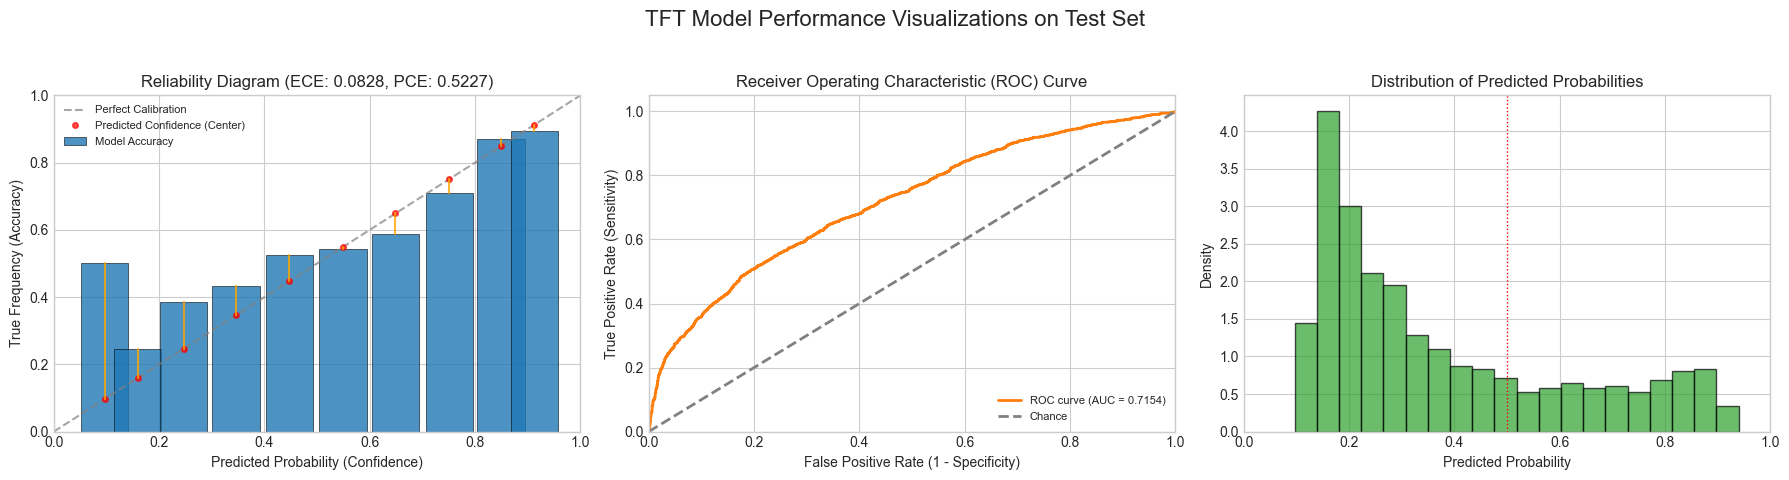

In [34]:
# ============================================================
# 14. VISUALIZATION OF METRICS 
# ============================================================

def plot_model_metrics(results_dict):
    """
    Generates three plots: Reliability Diagram (ECE/PCE), ROC Curve (AUC), 
    and Predicted Probability Distribution.

    Args:
        results_dict (dict): Dictionary containing raw and binned evaluation results.
    """
    y_true = results_dict['y_true']
    y_pred = results_dict['y_pred']
    binned_data = results_dict['binned_calibration_data']

    ece = results_dict['model_eval']['ece']
    pce = results_dict['model_eval']['pce']

    # --- Setup Figure ---
    # Use a clean, professional style for comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.style.use('seaborn-v0_8-whitegrid') 

    # --- Plot 1: Reliability Diagram (ECE/PCE) ---
    ax1 = axes[0]
    bin_centers = binned_data['bin_centers']
    bin_accuracies = binned_data['bin_accuracies']
    bin_confidences = binned_data['bin_confidences'] #

    # Filter out bins with no samples (NaNs)
    valid_mask = ~np.isnan(bin_accuracies)
    centers = bin_centers[valid_mask]
    accuracies = bin_accuracies[valid_mask]
    confidences = bin_confidences[valid_mask] 

    # Plot the diagonal line for perfect calibration
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7, label='Perfect Calibration')

    # Plot the Model's confidence/accuracy gap using bars
    bin_width = 1 / len(binned_data['bin_centers'])

    # Plot bars showing actual accuracy
    ax1.bar(confidences, accuracies, width=bin_width * 0.9, color='#1f77b4', alpha=0.8,
            edgecolor='black', linewidth=0.5, label='Model Accuracy')

    # Overlay confidence (center of the bin) as a line or dots to show the gap
    ax1.plot(confidences, confidences, 'o', color='red', alpha=0.7, markersize=4, label='Predicted Confidence (Center)') # 

    # Add lines connecting the center of the bin to the actual accuracy
    for c, a in zip(confidences, accuracies): # CHANGED: Use bin_confidences
        ax1.plot([c, c], [c, a], color='orange', linestyle='-', linewidth=1.5, alpha=0.8)


    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel('Predicted Probability (Confidence)')
    ax1.set_ylabel('True Frequency (Accuracy)')
    ax1.set_title(f'Reliability Diagram (ECE: {ece:.4f}, PCE: {pce:.4f})', fontsize=12)
    ax1.legend(loc='upper left', fontsize=8)


    # --- Plot 2: ROC Curve (AUC) ---
    ax2 = axes[1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    results_dict['roc_auc'] = roc_auc

    ax2.plot(fpr, tpr, color='C1', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Chance')

    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate (1 - Specificity)')
    ax2.set_ylabel('True Positive Rate (Sensitivity)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=12)
    ax2.legend(loc="lower right", fontsize=8)

    # --- Plot 3: Probability Distribution ---
    ax3 = axes[2]
    # Histogram of predicted probabilities, showing concentration
    ax3.hist(y_pred, bins=20, edgecolor='black', alpha=0.7, color='#2ca02c', density=True)
    ax3.set_xlim(0, 1)
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Density')
    ax3.set_title('Distribution of Predicted Probabilities', fontsize=12)

    # Mark the 0.5 decision boundary
    ax3.axvline(0.5, color='red', linestyle=':', linewidth=1)

    plt.suptitle("TFT Model Performance Visualizations on Test Set", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

    return results_dict

# Execute Plotting
print("\n" + "="*55)
print("           SECTION 14: MODEL VISUALIZATION (PLOTS)           ") 
print("="*55)

# The 'results' dictionary now contains all the necessary data
plots = plot_model_metrics(results)


In [35]:
plots

{'model_eval': {'ece': np.float64(0.08284066777752372),
  'pce': np.float64(0.5227292692280251),
  'kelly_roi': np.float64(-0.4469387488705771),
  'parlay_pce': np.float64(0.7975319852198356),
  'parlay_kelly_roi': np.float64(-0.181)},
 'single_prob': 0.4635559022426605,
 'parlay_prob': np.float64(0.21488407450400704),
 'y_true': array([0., 1., 1., ..., 0., 1., 0.], shape=(4900,), dtype=float32),
 'y_pred': array([0.22925466, 0.26996055, 0.70182514, ..., 0.19591582, 0.17705227,
        0.15860176], shape=(4900,), dtype=float32),
 'binned_calibration_data': {'bin_centers': array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]),
  'bin_accuracies': array([0.5       , 0.24678837, 0.384755  , 0.43321916, 0.52463055,
         0.54448396, 0.58666664, 0.7097902 , 0.870229  , 0.8955224 ],
        dtype=float32),
  'bin_confidences': array([0.09668642, 0.15928185, 0.24675436, 0.3458779 , 0.44737637,
         0.5491456 , 0.6488451 , 0.7513191 , 0.8492336 , 0.91267806],
        dtype

In [38]:
# ============================================================================
# 15. SAVE AGGREGATE METRICS FOR COMPARISON
# ============================================================================

print("\n" + "="*55)
print("         SECTION 14: SAVING METRICS FOR COMPARISON         ")
print("="*55)

# Assuming the 'results' variable holds the metrics from the evaluation step.
# ADJUST THE DICTIONARY KEYS BELOW ('ece', 'pce', 'roc_auc') if your results dictionary uses different names for the final aggregate metrics.
try:
    # 1. Define folder path and ensure it exists
    metrics_folder = 'metrics'
    os.makedirs(metrics_folder, exist_ok=True) 
    file_path = os.path.join(metrics_folder, 'tft_metrics.json')

    # 2. Extract metrics 
    tft_metrics = {
        'ECE': plots['model_eval']['ece'],
        'PCE': plots['model_eval']['pce'], 
        'AUC': plots['roc_auc']
    }

    # 3. Save to JSON file
    with open(file_path, 'w') as f:
        json.dump(tft_metrics, f, indent=4)
        
    print(f"TFT metrics (ECE: {tft_metrics['ECE']:.4f}, PCE: {tft_metrics['PCE']:.4f}, AUC: {tft_metrics['AUC']:.4f}) saved to '{file_path}'.")

except Exception as e:
    print(f"Error during metric saving: {e}")


         SECTION 14: SAVING METRICS FOR COMPARISON         
TFT metrics (ECE: 0.0828, PCE: 0.5227, AUC: 0.7154) saved to 'metrics/tft_metrics.json'.


## Investigation

    Increasing hidden layers size to 128 and number of heads to 4 from defaults.
        Best test loss: Epoch 09/15 | Train L=0.6131 A=70.6% | Test L=0.6471 A=65.9%
        Overall flow of learning is unstable still at increasing number of hidden & heads.
        
    Attempted adding L2 regularization to the ADAM optimizer at 1e-5.
        Failed by increasing loss and providing further instability during training. Moving to 1e-3.
        Best: Epoch 14/15 | Train L=0.7649 A=72.5% | Test L=0.8044 A=69.1%
        Moving to weight_decay of 1e-2 which increased stability but still unstable learning.
    Attempting a more base case to train on 'Xavier Worthy' getting over 3 receptions (should be highly likely).
        This decreased overall accuracy range when running the model to around 65-66% without improvement

Summary:

    The model is very confident in its predictions even though the accuracy is relatively low (below 80%) and the loss ECE is high with .1133 (about .05-.1 expected).